In [2]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

def fun_r(x, lamda_i, y_i, y_x, y_xx):
    return y_xx + lamda_i*y_i

N_b = 200
N_r = 100
yb = 0

tf.random.set_seed(0)

lb = tf.constant(0, dtype=DTYPE)
# Upper bounds
ub = tf.constant(1, dtype=DTYPE)

X_b = tf.linspace(0,1,2)
y_b = yb*tf.ones((len(X_b),1))

X_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)

X_data = [X_b]
y_data = [y_b]

def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)
    # act_list = [tf.keras.activations.get('tanh'), tf.keras.activations.get('relu'), tf.keras.activations.get('mish'), tf.keras.activations.get('silu')]
    # Append hidden layers
    for _ in range(num_hidden_layers):
        # act_func = random.choice(act_list)
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('silu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

def get_r(model, X_r, lamda_i, y_i):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x = X_r[:, 0:1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)

        # Determine residual 
        y = model(x)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        y_x = tape.gradient(y, x)
            
    # u_t = tape.gradient(u, t)
    y_xx = tape.gradient(y_x, x)

    del tape

    return fun_r(x, lamda_i, y_i, y_x, y_xx)

def compute_loss(model, X_r, X_data, y_data, lamda_i, y_i):
    
    # Compute phi^r
    r = get_r(model, X_r, lamda_i, y_i)
    y_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = y_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        y_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(y_data[i] - y_pred))
    
    return loss

def get_grad(model, X_r, X_data, y_data, lamda_i, y_i):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, y_data, lamda_i, y_i)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

# Initialize model aka u_\theta
model = init_model(4, 10)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(lamda_i, phi_i):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, y_data, lamda_i, phi_i)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

def infty_norm(x):
    return np.max(np.abs(x))


In [3]:
# Number of training epochs
N = 5000

lamda0 = 10.0
def base_model(x):
    return -x*(x-1)
y0 = base_model(X_r)
arr_lamda = [lamda0]
arr_y = [y0]

# Start timer
for j in range(10):
    t0 = time()
    hist = []
    for i in range(N+1):
        
        loss = train_step(arr_lamda[-1], arr_y[-1])
        
        # Append current loss to hist
        hist.append(loss.numpy())
        
        # Output current loss after 50 iterates
        if i%50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        if i > 100:
            if (np.abs(np.diff(np.array(hist)))[-100:] < 1e-5).all():
                print('stop iteration for j=',j,' is ',i)
                break
    if loss < 5e-2:
        phi_est = model(X_r)
        norm_phi = infty_norm(phi_est)
        arr_y.append(phi_est/norm_phi)
        arr_lamda.append(arr_lamda[-1]/norm_phi)
        arr_lamda[-1] = arr_lamda[-1].astype('float32')
        print('lamda-', j,': ', arr_lamda[-1])
        print('norm phi: ', norm_phi)
    else:
        print('failed')
        break
            
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.02014232e+00
It 00050: loss = 2.64650211e-02
It 00100: loss = 3.98844201e-03
It 00150: loss = 2.45163427e-03
It 00200: loss = 1.59878400e-03
It 00250: loss = 9.12384072e-04
It 00300: loss = 4.47511149e-04
It 00350: loss = 1.97760368e-04
stop iteration for j= 0  is  367
lamda- 0 :  38.37371
norm phi:  0.26059508

Computation time: 4.308342695236206 seconds
It 00000: loss = 6.21925049e+02
It 00050: loss = 6.86542153e-01
It 00100: loss = 2.21930355e-01
It 00150: loss = 1.84109345e-01
It 00200: loss = 1.58585653e-01
It 00250: loss = 1.38189614e-01
It 00300: loss = 1.21104196e-01
It 00350: loss = 1.06399305e-01
It 00400: loss = 9.36046615e-02
It 00450: loss = 8.24604854e-02
It 00500: loss = 7.27567449e-02
It 00550: loss = 6.42662793e-02
It 00600: loss = 5.67486584e-02
It 00650: loss = 5.19796833e-02
It 00700: loss = 5.13052903e-02
It 00750: loss = 5.06138764e-02
It 00800: loss = 4.99047861e-02
It 00850: loss = 4.91798706e-02
It 00900: loss = 4.84385826e-02
It 00950: loss 

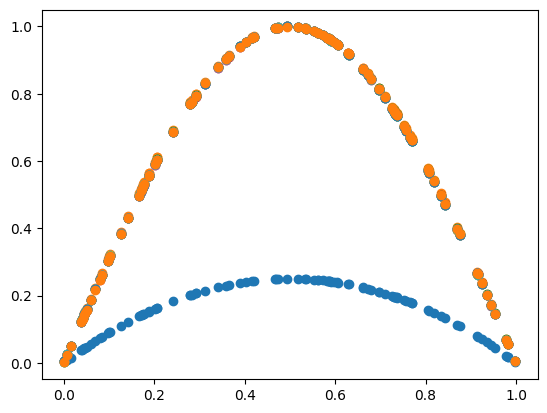

In [4]:
import matplotlib.pyplot as plt
arr_x = tf.linspace(0,1,100)
y_pred = model(arr_x)

for i in arr_y:
    plt.scatter(X_r,i)

plt.scatter(X_r, tf.sin(pi*X_r))

In [5]:
def compute_loss_inner(model, X_r, lamda_i, y_i):
    
    # Compute phi^r
    r = get_r(model, X_r, lamda_i, y_i)
    phi_r = tf.square(r)
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    # for i in range(len(X_data)):
    #     phi_pred = model(X_data[i])
    #     loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss.numpy()

def compute_loss_data(model, X_data, phi_data):
    
    # Compute phi^r
    # r = get_r(model, X_r)
    # phi_r = tf.square(r)
    
    # Initialize loss
    loss = []
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(phi_data)):
        phi_pred = model(X_data[i])
        loss.append(tf.square(phi_data[i] - phi_pred).numpy())
        # print(tf.square(phi_data[i] - phi_pred).numpy())
    return loss

In [6]:
err = compute_loss_inner(model, X_r, pi, arr_y[-1])

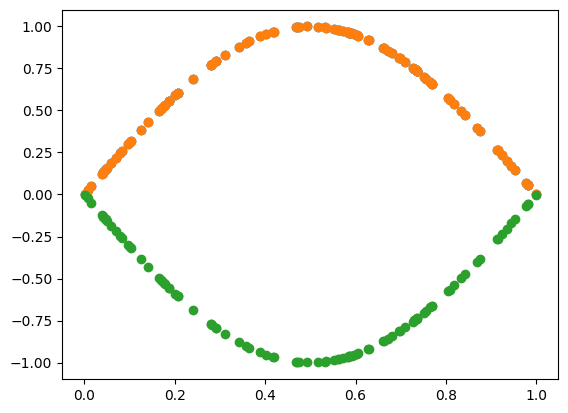

In [7]:
plt.scatter(X_r, arr_y[-1])
plt.scatter(X_r, model(X_r))
plt.scatter(X_r, -tf.sin(pi*X_r))

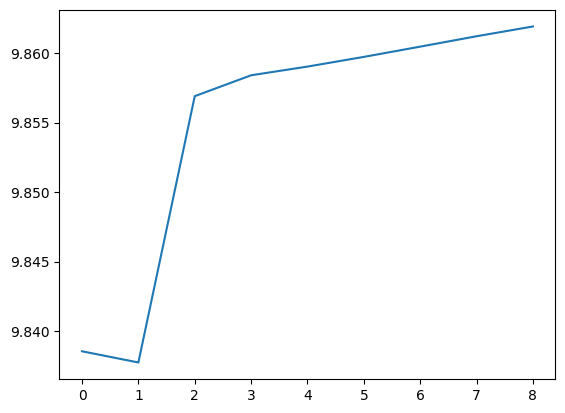

In [9]:
plt.plot(arr_lamda[2:])